In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import numpy as np
from numpy.linalg import inv

from skimage import exposure
from scipy.spatial import distance

# Load Image

Let's load an image first and display it.

Image Shape: (450, 450, 3)


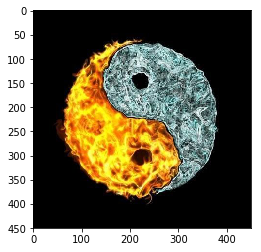

In [2]:
# Load Image
image = Image.open('yingyang1.jpg', 'r')
image = image.convert('RGB')
image = np.asarray(image)

# Display Image
print("Image Shape: " + str(image.shape))
plt.imshow(image)
plt.show()

# Extract an Image Patch

In [3]:
def extract_patch(image, center_x, center_y, size):
    assert(size % 2 == 1)
    
    left = center_x - (size // 2)
    top = center_y - (size // 2)
    
    right = center_x + (size // 2) + 1
    bottom = center_y + (size // 2) + 1
    
    patch = image[top:bottom,left:right]
    return patch


def display_patch_location(image, center_x, center_y, size):
    assert(size % 2 == 1)
    
    left = center_x - (size // 2)
    top = center_y - (size // 2)

    # Display Image
    fig,ax = plt.subplots(1, figsize=(5,5))
    ax.imshow(image)
    
    # Display Patch Location
    rect = patches.Rectangle((left,top), size, size, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    plt.show()

Let's extract a patch from this image. For now let's just choose a patch at the location [86,150] of size [21]x[21]. Later we can also change that size. We just should keep in mind, that it always needs to be odd, so that the patch has a single center pixel.

Patch Shape:(21, 21, 3)


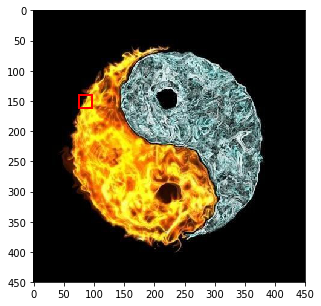

In [4]:
patch_size = 21
patch_x = 86
patch_y = 150

# Extract Patch from Image
patch = extract_patch(image, patch_x, patch_y, patch_size)

# Display Patch Location
print("Patch Shape:" + str(patch.shape))
display_patch_location(image, patch_x, patch_y, patch_size)

Let's also take a closer look at the patch.

Patch Shape: (21, 21, 3)
(441 Pixels)


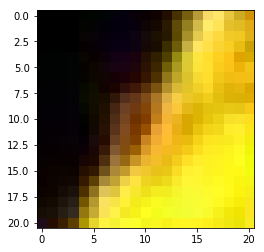

In [5]:
# Display Patch
print("Patch Shape: " + str(patch.shape))
print("(" + str(patch.shape[0]*patch.shape[1]) + " Pixels)")
plt.imshow(patch)
plt.show()

# Calculate Transformation Parameters

You can find details of the approach here:  https://hal-ujm.archives-ouvertes.fr/ujm-01486570/document

In [6]:
def prepare_data(patch):
    x_dim, y_dim, _ = patch.shape
    numPixels = x_dim * y_dim
    
    # Generate Image Coordinates of the Patch Space (Input)
    left   = -1.0 * (x_dim // 2)
    right  = (x_dim // 2) + 1
    top    = -1.0 * (y_dim // 2)
    bottom = (y_dim // 2) + 1
    
    Pa = np.meshgrid(np.arange(left, right), np.arange(top, bottom))
    Pa = np.asarray(Pa).reshape(2, -1)
    
    ones = np.ones(numPixels).reshape(-1, numPixels)
    Pa = np.concatenate((Pa,ones))
    
    # Generate Color Coordinates of the Color Space (Output)
    x_idx = (Pa[0,:] + (x_dim // 2)).astype(int)
    y_idx = (Pa[1,:] + (y_dim // 2)).astype(int)
    
    Co = patch[x_idx, y_idx]
    Co = Co.T
    
    # Changes Data Types to Double and put into right Shape
    Pa = Pa.astype('d')
    Co = Co.astype('d')
    
    return Pa, Co


def calc_transform_params(Pa, Co):
    Pa1 = Pa.T
    Co1 = Co.T
    
    # Calculate Parameters
    Af1 = inv(Pa1.T @ Pa1) @ Pa1.T @ Co1
    Af = Af1.T
    
    return Af

Due to different illumination conditions or orientations, we can not directly compare two patches pixel by pixel. If we did it this way, it would not even recognize, that a patch and a rotated version of it are the same. Thus, we need to create some kind of descriptor, that is invariant regarding these influences. The approach in the paper is to map the patch coordinate space (Pa) to patch color space (Co), i.e. our inputs are pixel coordinates in 2D and our outputs are their corresponding color values (RGB) in 3D. The mapping ( resp. affine transformation) can be expressed as equation as follows: `Pa * x = Co`. The parameters `x` of the equation should serve as our descriptor of the patch at the end. We can obtain them by a [least-square solution](https://en.wikipedia.org/wiki/Least_squares). 

Therefor, we need to collect the data first, i.e. we take all the coordinates of the patch and all their corresponding color values and put them in two matrices `Pa` and `Co`, where each column corresponds to one pixel. The rows of `Pa` are organized as `[x,y,1` (the ones are only there to make the math work out later) and the rows of `Co` are organized as `[red,green,blue]`. Furthermore, it is also important to mention, that regarding our coordinate data in `Pa` we make the middle pixel of the patch to our origin `[0,0]`, i.e. left and above of it we have negative indices.

In [7]:
Pa, Co = prepare_data(patch)

print("Pa Shape: " + str(Pa.shape))
print(Pa)
print()
print("Co Shape: " + str(Co.shape))
print(Co)

Pa Shape: (3, 441)
[[-10.  -9.  -8. ...   8.   9.  10.]
 [-10. -10. -10. ...  10.  10.  10.]
 [  1.   1.   1. ...   1.   1.   1.]]

Co Shape: (3, 441)
[[  0.   0.   0. ... 249. 252. 247.]
 [  0.   0.   0. ... 232. 229. 235.]
 [  0.   0.   0. ...  30.  35.  35.]]


Since we have prepared the data now, we can finally calculate the transformation parameters `x`. However, to be consistent with the paper, let us call these parameters `Af` in the following, which referres to the term "affine transformation". Moreover, I need to make one change regarding the approach in the paper though. In the paper the parameters are calculated by `Af = Co * inverse(transpose(Pa) * Pa) * transpose(Pa)`. However, this gave me a singular matrix error. I am not quite sure how it was exactly done by the authors of the paper. Nevertheless, we can just use the [ordinary least squares equation](https://en.wikipedia.org/wiki/Ordinary_least_squares) `x = inverse(transpose(A) * A) * transpose(A) * B`. However, therefor we need to change our problem from `x * A = B` (as described in the paper) to the form `A * x = B` (as already described above), i.e. we need to go from `Af * Pa = Co` to `transpose(Pa) * transpose(Af) = transpose(Co)` (to change the ordering between`Af` and `Pa`). This means, that we change our matrices `Pa` to `Pa' = transpose(Pa)`, `Co` to `Co' = transpose(Co)` and `Af` to `Af' = transpose(Af)`. As a result our final equation for calculating the transformation parameters `Af` is `Af' = inverse(transpose(Pa') * Pa') * transpose(Pa') * Co'` and then `Af = transpose(Af')`.

In [8]:
Af = calc_transform_params(Pa, Co)

print("Af Shape: " + str(Af.shape))
print(Af)

Af Shape: (3, 3)
[[  6.62671614  14.52677798 138.31292517]
 [  6.90030921  13.32789116 117.9138322 ]
 [  0.71713049   1.56864564  22.05442177]]


# Get Rotation Invariant Descriptor

You can find details of the approach here:  https://hal-ujm.archives-ouvertes.fr/ujm-01486570/document

In [9]:
def decomp_transform_params(Af):
    M = Af[:,0:2].reshape(3,2)
    T = Af[:,2].reshape(3,1)
    return M, T


def decomp_rotation_params(M):
    Q, R = np.linalg.qr(M.T, mode='complete')
    return Q, R

According to the paper, the transformation matrix `Af` contains rotation, scale and stretch parameters in the first two columns and translation parameters in the third column. Since translation parameters should be the same for two similar patches regarding the local patch-based coordinate system with the origin `[0,0]` in the center pixel, we can use them for our final descriptor. So, let us extract them by decomposing `Af` into a matrix `M` (rotation, scale and strect) and a matrix `T` (translation).

In [10]:
M, T = decomp_transform_params(Af)

print("Af Shape: " + str(Af.shape))
print(Af)
print()
print("M Shape: " + str(M.shape))
print(M)
print()
print("T Shape: " + str(T.shape))
print(T)

Af Shape: (3, 3)
[[  6.62671614  14.52677798 138.31292517]
 [  6.90030921  13.32789116 117.9138322 ]
 [  0.71713049   1.56864564  22.05442177]]

M Shape: (3, 2)
[[ 6.62671614 14.52677798]
 [ 6.90030921 13.32789116]
 [ 0.71713049  1.56864564]]

T Shape: (3, 1)
[[138.31292517]
 [117.9138322 ]
 [ 22.05442177]]


The matrix `M` in contrast would not be similar for similar patches, if one is a rotated version of the other. However, it consists of a rotation dependent and a rotation independent part. We can decompose `M` to obtain the rotation independent part, which can be also used for our final descriptor besides the translation parameters `T`. To decompose they chose QR factorization in the paper. The resulting `Q` matrix is the rotation matrix (to calculate it we took the transpose of `M` since this results in a 2x2 `Q` matrix, which makes sense, because we have a rotation in 2D) and the `R` matrix is a triangluar upper right matrix. The latter is our rotation independent part, which we can also use for our final descriptor.

In [11]:
Q, R = decomp_rotation_params(M)

print("Q Shape: " + str(Q.shape))
print(Q)
print()
print("R Shape: " + str(R.shape))
print(R)

Q Shape: (2, 2)
[[-0.41502937 -0.90980802]
 [-0.90980802  0.41502937]]

R Shape: (2, 3)
[[-1.59668609e+01 -1.49896532e+01 -1.72479659e+00]
 [ 0.00000000e+00 -7.46490412e-01 -1.41706065e-03]]


Hence, our final descriptor consists of eight values. Three values of the transpose matrix `T` and five values of the rotation independent matrix `R` (it is actually a 2x3 matrix, but since it is a triangluar upper right matrix, one element is always zero).

# Compare Patches

In [12]:
def calc_similarity(v1, v2):
    similarity = 1.0 / (1.0 + distance.euclidean(v1, v2))
    return similarity


def calc_descrip_similarity(T1, R1, T2, R2):
    # Prepare Descriptors
    _R1 = np.concatenate((R1[0,:],R1[1,1:])).reshape(5,1)
    _R2 = np.concatenate((R2[0,:],R2[1,1:])).reshape(5,1)
    
    _T1 = T1.reshape(3,1)
    _T2 = T2.reshape(3,1)
    
    # Compute Similarities
    t_similarity = calc_similarity(_T1, _T2)
    r_similarity = calc_similarity(_R1, _R2)
    
    return 0.5*t_similarity + 0.5*r_similarity


def calc_patch_similarity(patch1, patch2):
    # Create Descriptor for Patch 1
    Pa1, Co1 = prepare_data(patch1)
    Af1 = calc_transform_params(Pa1, Co1)
    M1, T1 = decomp_transform_params(Af1)
    Q1, R1 = decomp_rotation_params(M1)
    
    # Create Descriptor for Patch 2
    Pa2, Co2 = prepare_data(patch2)
    Af2 = calc_transform_params(Pa2, Co2)
    M2, T2 = decomp_transform_params(Af2)
    Q2, R2 = decomp_rotation_params(M2)
    
    # Compute Similarity between Patch 1 and Patch 2
    similarity = calc_descrip_similarity(T1, R1, T2, R2)
    return similarity


def calc_image_similarities(image, patch):
    patch_size, _, _ = patch.shape
    image_y_dim, image_x_dim, _ = image.shape
    
    left = patch_size // 2
    right = image_x_dim - (patch_size // 2)
    top = patch_size // 2
    bottom = image_y_dim - (patch_size // 2)
    
    # Calculate the similarity for all Image Patches
    similarity_matrix = np.zeros((image_y_dim, image_x_dim), dtype='d')
    for y in np.arange(top, bottom):
        for x in np.arange(left, right):
            window = extract_patch(image, x, y, patch_size)
            similarity = calc_patch_similarity(window, patch)        
            similarity_matrix[y,x] = similarity
    
    return similarity_matrix


def plot_image_similarities(image, patch, similarities):
    fig = plt.figure(figsize=(15,10))
    plt.subplot(131)
    plt.imshow(patch)
    plt.subplot(132)
    plt.imshow(image)
    plt.subplot(133)
    plt.imshow(similarities, cmap='gray')

Unfortunately, I could not find in the paper how the authors compare two patches at the end. They just write, that if the patches are the same, their transpose matrices and their `R` matrices will be the same as well. However, I assume in practice they probably won't be exactly the same in a lot of cases. Moreover, what is with patches, that are similar but not the same? So, we rather need a similarity measure here. But how can we calculate such a similarity? For now I just chose to calculate the euclidean distance between the `T` and `R` matrices and use this as our similarity measure.

In [13]:
similarity_matrix = calc_image_similarities(image, patch)
print("Similarity Matrix Shape: " + str(similarity_matrix.shape))

Similarity Matrix Shape: (450, 450)


Let's visualize the similarities, i.e. which locations of the image are similar to our extracted patch from above.

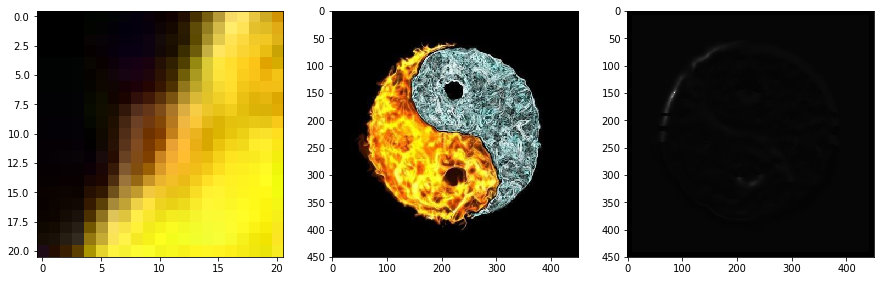

In [14]:
plot_image_similarities(image, patch, similarity_matrix)

Now, let's try a slightly more complicated case.

Image Shape: (518, 655, 3)


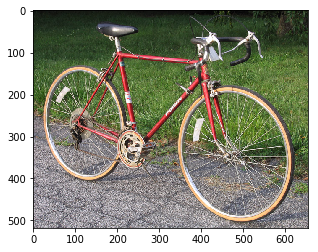

In [15]:
# Load Image
image = Image.open('bicycle.jpg', 'r')
image = image.convert('RGB')
image = np.asarray(image)

# Display Image
print("Image Shape: " + str(image.shape))
plt.imshow(image)
plt.show()

Patch Shape:(21, 21, 3)


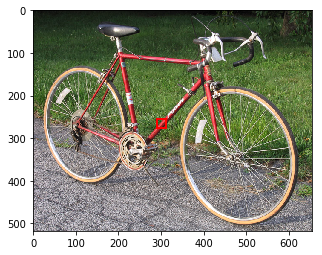

In [16]:
patch_size = 21
patch_x = 300
patch_y = 265

# Extract Patch from Image
patch = extract_patch(image, patch_x, patch_y, patch_size)

# Display Patch Location
print("Patch Shape:" + str(patch.shape))
display_patch_location(image, patch_x, patch_y, patch_size)

Patch Shape: (21, 21, 3)
(441 Pixels)


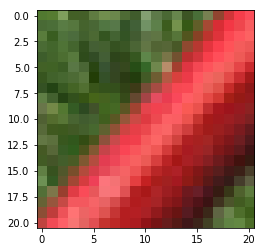

In [17]:
# Display Patch
print("Patch Shape: " + str(patch.shape))
print("(" + str(patch.shape[0]*patch.shape[1]) + " Pixels)")
plt.imshow(patch)
plt.show()

In [18]:
similarity_matrix = calc_image_similarities(image, patch)
print("Similarity Matrix Shape: " + str(similarity_matrix.shape))

Similarity Matrix Shape: (518, 655)


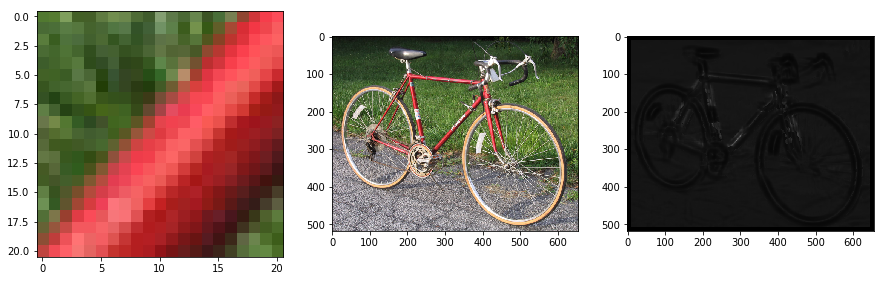

In [19]:
plot_image_similarities(image, patch, similarity_matrix)

# Photometric Invariance

In [20]:
def normalize_image(image):
    red_channel = image[:,:,0]
    green_channel = image[:,:,1]
    blue_channel = image[:,:,2] 
    
    # Normalize each Color Channel
    norm_red = exposure.equalize_hist(red_channel)
    norm_green = exposure.equalize_hist(green_channel)
    norm_blue = exposure.equalize_hist(blue_channel)
    
    # Put all Channels back together
    norm_image = np.dstack((norm_red,norm_green))
    norm_image = np.dstack((norm_image,norm_blue))
    
    return norm_image

At last, I wanted to try something out, which was noted in a older paper from the authors [Song et al., 2009]: Normalizing the image to obtain a illumination invariant version of it. Therefor they divide the image in its color channels and normalize each channel by the histogram equalization method. Usually, this is only used for grayscale images to improve their contrast, but not for color images, since it is supposed to result in weird colors sometimes. However, the appearance is not important for us here. We just want to have an image that is independent of illumination.

Let's load and display the original image first.

Image Shape: (450, 450, 3)


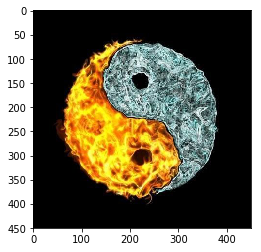

In [21]:
# Load Image
image = Image.open('yingyang1.jpg', 'r')
image = image.convert('RGB')
image = np.asarray(image)

# Display Image
print("Image Shape: " + str(image.shape))
plt.imshow(image)
plt.show()

Now let's normalize the image. Furthermore, although it doesn't make too much sense, let's still display it.

Normalized Image Shape: (450, 450, 3)


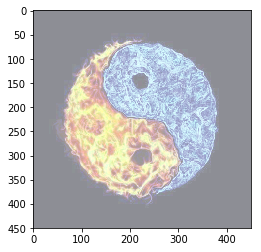

In [22]:
# Normalize Image
image = normalize_image(image)

# Display Normalized Image
print("Normalized Image Shape: " + str(image.shape))
plt.imshow(image)
plt.show()

The colors really look a bit weird now. It seems like it lost colors. Let's extract the patch.

Patch Shape:(21, 21, 3)


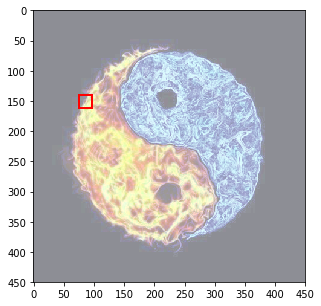

In [23]:
patch_size = 21
patch_x = 86
patch_y = 150

# Extract Patch from Image
patch = extract_patch(image, patch_x, patch_y, patch_size)

# Display Patch Location
print("Patch Shape:" + str(patch.shape))
display_patch_location(image, patch_x, patch_y, patch_size)

Patch Shape: (21, 21, 3)
(441 Pixels)


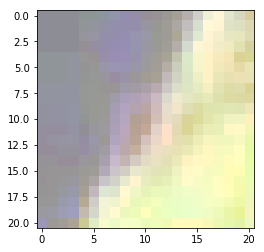

In [24]:
# Display Patch
print("Patch Shape: " + str(patch.shape))
print("(" + str(patch.shape[0]*patch.shape[1]) + " Pixels)")
plt.imshow(patch)
plt.show()

A close look at the patch make the colors appear even more weird. Let's calculate the similarities and see if we have any difference.

In [25]:
similarity_matrix = calc_image_similarities(image, patch)
print("Similarity Matrix Shape: " + str(similarity_matrix.shape))

Similarity Matrix Shape: (450, 450)


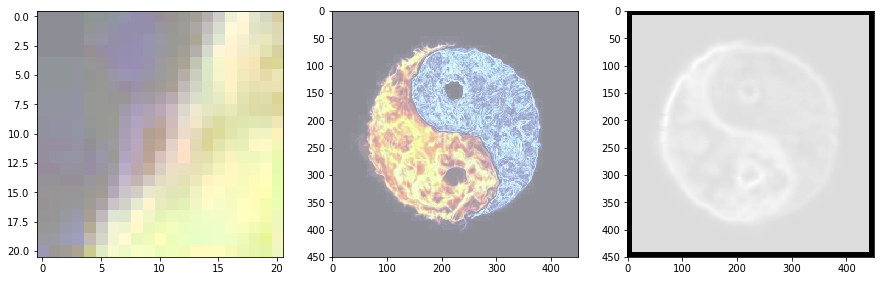

In [26]:
plot_image_similarities(image, patch, similarity_matrix)

Woah! We have a lot of change. Now the edges of the whole circle seems to appear a bit better. But although all other regions (incl. the background) show a lot higher similarity. I'm actually not quite sure if this is correct.